# Data Assimilation using ESMDA in Reservoir Simulation

*Advanced Data Assimilation using Ensemble Smoother Multiple Data Assimilation (ESMDA) in Reservoir Simulation.*

This notebook demonstrates how to apply Ensemble Smoother Multiple Data Assimilation (ESMDA) in reservoir simulation. ESMDA is a data assimilation method that integrates observations and models to produce an improved estimate of the state of a system; in this case, a synthetic reservoir.

### Objectives

- Understand the ESMDA algorithm for data assimilation 
- Explore the effect of different ensemble sizes, perturbations, and number of assimilation steps
- Analyze the convergence and effectiveness of the ESMDA method in a synthetic reservoir model

### Prerequisites
- Knowledge of Python
- Familiarity with Data Assimilation Methods
- Understanding of Reservoir Simulation Models

## TODOs
- replace covariance matrix by a sparse matrix
- move ESMDA to rs

## Understanding the reservoir simulator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from reservoir_simulator import Simulator, covariance

#%load_ext autoreload
#%autoreload 2   
#%load_ext line_profiler
#%load_ext memory_profiler
    
# Instantiate the random number generator
rng = np.random.default_rng(1103)

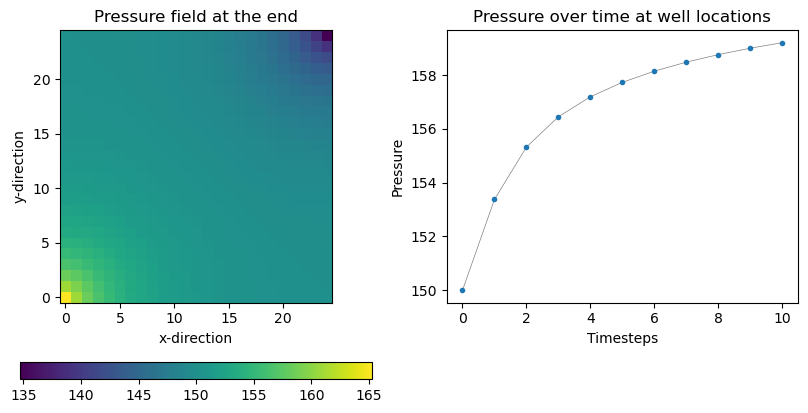

In [2]:
nx = 25 #20 # 60
ny = 25 #10 # 30
perm_field = np.ones((nx, ny)) * 100  # Replace with your actual perm field

# Observation indices (should be well locations)
ox, oy = 1, 1

#wells = np.array([[15, 10, 180], [55, 25, 120], [30, 7, 140]])
wells = None

Reservoir = Simulator(perm_field=perm_field, wells=wells)
pressure_history = Reservoir(dt=np.ones(10)*0.0001)

# Plot the result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
ax1.set_title('Pressure field at the end')
im = ax1.imshow(pressure_history[-1, :, :].T, origin='lower', aspect='equal')
ax1.set_xlabel('x-direction')
ax1.set_ylabel('y-direction')
fig.colorbar(im, ax=ax1, orientation='horizontal')
ax2.set_title('Pressure over time at well locations')
ax2.plot(pressure_history[:, ox, oy], '.5', lw=0.5)
ax2.plot(pressure_history[:, ox, oy], '.')
ax2.set_xlabel('Timesteps')
ax2.set_ylabel('Pressure');

## Create permeability maps for for ESMDA

## TODO - change cov-matrix to a sparse matrix

We will create a set of permeability maps that will serve as our initial guess (prior). These maps are generated using a Gaussian random field and are constrained by certain statistical properties.

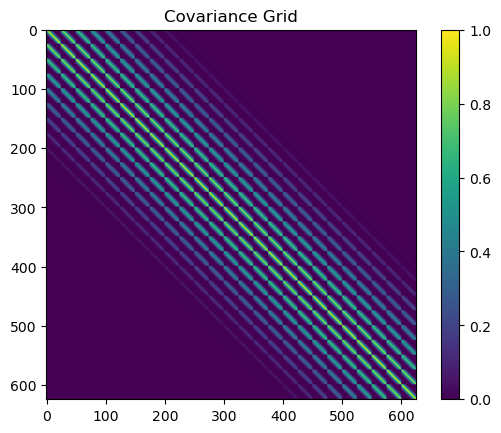

In [3]:
# Generate the covariance matrix
cov = covariance(nx, ny, length=(10, 10), theta=45, sigma_pr2=1.0)

fig, ax = plt.subplots()
ax.set_title('Covariance Grid')
im = ax.imshow(cov, aspect='equal')
fig.colorbar(im, ax=ax)

Text(0, 0.5, 'y-direction')

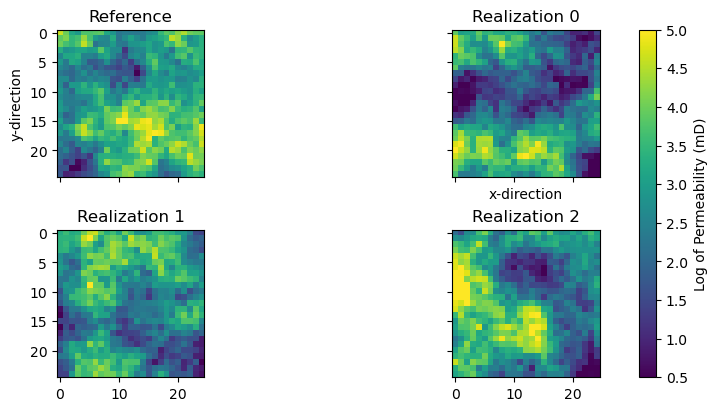

In [4]:
ne = 100    # number of ensembles
nc = nx*ny

# Generate the ensembles
lCholesky = np.linalg.cholesky(cov)

mList = np.full((ne+1, nx, ny), 3.0, order='F')  # <= What is this three? => add to random

for i in range(ne+1): #+1 for the reference model
    z = rng.normal(size=nc)
    mList[i, ...] += (lCholesky @ z).reshape((nx, ny), order='F')

#clip the mList to min = 0.5 and max = 5 (related to MGrid values)
bound_max= 5
bound_min= 0.5
mList = np.clip(mList, bound_min, bound_max)

# Set a reference model
MReference = mList[0, ...]
# Use the remaining elements for MGridPrior
MGridPrior = mList[1:, ...]

fig, axs = plt.subplots(2, 2, figsize=(9, 4), sharex=True, sharey=True, constrained_layout=True)
axs = axs.ravel()
for i, t in enumerate(['Reference', 'Realization 0', 'Realization 1', 'Realization 2']):
    axs[i].set_title(t)
    im = axs[i].imshow(mList[i, ...].T, vmin=bound_min, vmax=bound_max)
fig.colorbar(im, ax=axs, label='Log of Permeability (mD)')
axs[1].set_xlabel('x-direction')
axs[0].set_ylabel('y-direction')

## Run the prior models and the reference case

In [5]:
#simulate all 101 fields
simulated_pressure_history = np.zeros((ne, *pressure_history.shape))
dt = np.ones(10)*0.0001
RS = Simulator(perm_field=np.exp(MGridPrior[0, :, :]), wells=wells)
for i, perm_field in enumerate(MGridPrior):
    simulated_pressure_history[i, ...] = RS(dt=dt, perm_field=np.exp(perm_field))

simulated_pressure_history_prior = simulated_pressure_history
#getting only data we will use as observation
DPrior = simulated_pressure_history[:, :, ox, oy]

In [6]:
#simulate the reference field
reference_pressure_history = RS(dt=dt, perm_field=np.exp(MReference))

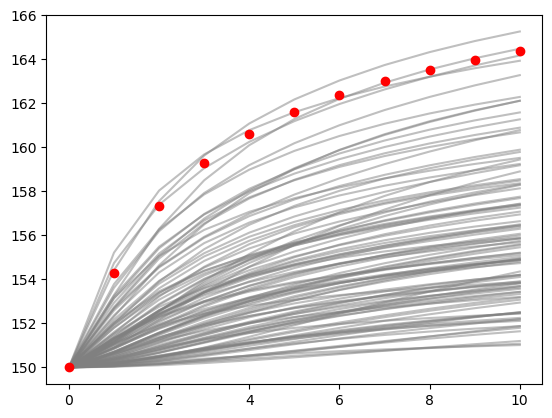

In [7]:
#plot the monitored pressure at cell (1,1) for all 11 fields - consider the last simulation 101 as the reference case
for i in range(ne):
    plt.plot(simulated_pressure_history[i,:,ox, oy], color='gray', alpha=0.5)
plt.plot(reference_pressure_history[:,ox, oy], label='reference case' , marker='o', linestyle='', color = 'red')

### Create the perturbed observations for ESMDA

We will create a set of perturbed observations that will serve as our observations for ESMDA. These observations are generated by adding a random noise to the reference case observations.

In [8]:
#using the last model to create synthetic data
# Observations
dObs = reference_pressure_history[:,ox,oy]  
Nd = dObs.size
dstd = 2 * np.ones_like(dObs)
# Associated standard deviation: ones (for this scenario)
dstd = np.ones(dObs.size)*0.1
Ce = np.diag(dstd**2)


### ESMDA

Here we implement the ESMDA algorithm. This involves multiple assimilation steps, where we update our model parameters using observed data. The key components include:

Perturbing the observed data.

Calculating the Kalman gain.

Updating the model parameters.

Each assimilation step refines our model parameters, aiming to reduce the discrepancy between the model and the observed data.

In [9]:
Na = 4 #number of assimilation steps
alphas = np.ones(Na)*Na

In [10]:
D_iterations = np.zeros((Na, ne, Nd))

for l, alpha in enumerate(alphas):

    print(f"\nAssimilation step {l+1}")  
    Dobs = np.transpose(dObs + alphas[0]*dstd*rng.normal(size=(ne, Nd))) #perturb the observation for each ensemble member
    
    if l==0:   
        MGrid = MGridPrior
        D = DPrior 
        
    else:
        
        total_simulations = ne
        
        # DONT CALL IT THE SAME!
        simulated_pressure_history = np.zeros((ne, *pressure_history.shape))
        for i, perm_field in enumerate(MGrid):
            simulated_pressure_history[i, ...] = RS(dt=dt, perm_field=np.exp(perm_field))
    
        #getting only data we will use as observation
        D = simulated_pressure_history[:,:,1,1]   

    D_iterations[l, :] = D
    
    deltaM = MGrid - MGrid.mean(axis=0) #mean of the ensemble parameters
    deltaD = (D.T - D.mean(axis=1)).T #mean of the ensemble data
    # np.linalg.inv does not work well for real-live problems:
    # use subspace inversions  with woodbury matrix identity
    K = (deltaM.T@deltaD)@np.linalg.inv((deltaD.T@deltaD + alphas[0]*(ne-1)*Ce)) #Kalman gain
    Mnew = MGrid + (K@(Dobs-D.T)).T #update the ensemble parameters
    MGrid= np.clip(Mnew, bound_min, bound_max) #clip the ensemble parameters to min = 0.5 and max = 5 (related to MGrid values)  
       
MGridPost = MGrid



Assimilation step 1

Assimilation step 2

Assimilation step 3

Assimilation step 4


### Posterior Analysis
After running ESMDA, it's crucial to analyze the posterior ensemble of models. Here, we visualize the first three realizations from both the prior and posterior ensembles to see how the models have been updated.

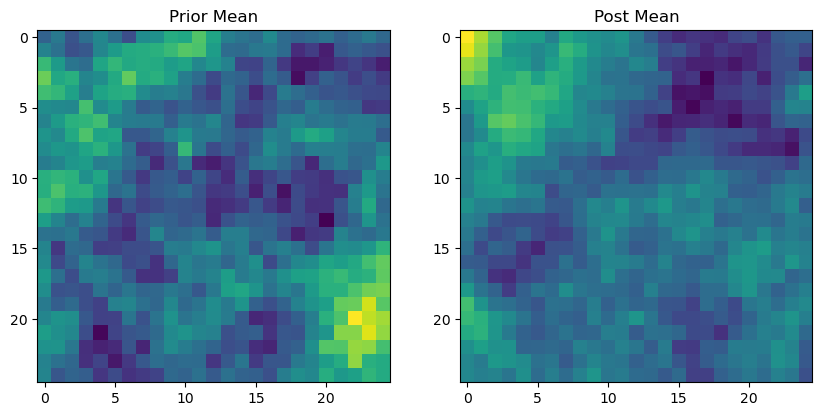

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(MGridPrior.mean(axis=0).T, label = 'Prior Mean')
ax[0].set_title('Prior Mean')
ax[1].imshow(MGridPost.mean(axis=0).T, label= 'Post Mean')
ax[1].set_title('Post Mean')
plt.show()

In [12]:
#Run the posterior
simulated_pressure_history = np.zeros((ne, *pressure_history.shape))
for i, perm_field in enumerate(MGridPost):
    simulated_pressure_history[i, ...] = RS(dt=dt, perm_field=np.exp(perm_field))

DPost = simulated_pressure_history[:,:,1,1]

Observing the monitored pressure at cell (1,1) for all realizations and the reference case, we can see that the ensemble of models after the assimilation steps (in blue) is closer to the reference case (in red) than the prior ensemble (in gray). This indicates that the ESMDA method is effectively updating the models to better represent the observed data.

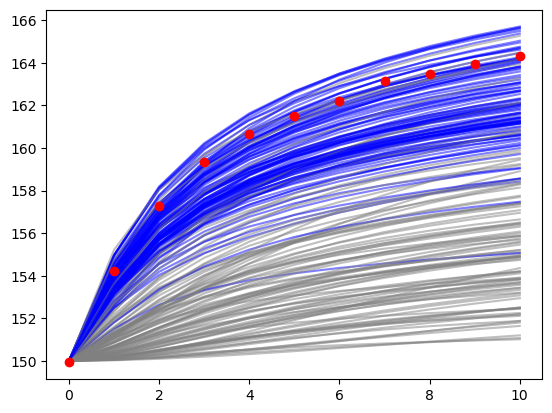

In [13]:
#plot the monitored pressure at cell (1,1) for all 11 fields - consider the last simulation 101 as the reference case
noisy_obs = dObs + rng.normal(0, dstd, size=len(dObs))

for i in range(ne):
    plt.plot(DPrior[i,:], color='gray', alpha=0.5)
    plt.plot(DPost[i,:], color='blue', alpha=0.5)
plt.plot(noisy_obs, label='reference case' , marker='o', linestyle='', color = 'red')

In [14]:
import scooby
scooby.Report()

--------------------------------------------------------------------------------
  Date: Tue Apr 16 17:20:28 2024 CEST

                OS : Linux
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
               RAM : 31.0 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06)
  [GCC 11.3.0]

             numpy : 1.24.4
             scipy : 1.11.1
           IPython : 8.12.0
        matplotlib : 3.7.2
            scooby : 0.7.2

  Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804
  for Intel(R) 64 architecture applications
--------------------------------------------------------------------------------